 <img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
 <h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

 # Text Summarization

 Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
 Датасет: gazeta.ru


 `Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

 Загрузим датасет и необходимые библиотеки

In [1]:
import warnings

# ipykernel DeprecationWarning issue fixed:
# https://github.com/ipython/ipykernel/issues/540#event-4516423938
# but ipykernel 6.0 has not been released yet.
warnings.filterwarnings("ignore", module="ipykernel", category=DeprecationWarning)

 Student: Oleg Navolotsky / Олег Наволоцкий  
 Stepik: https://stepik.org/users/2403189  
 Telegram: [@oleg_navolotsky](https://t.me/oleg_navolotsky)  

 **Note**: reproducibility depends on [different things](https://pytorch.org/docs/stable/notes/randomness.html):
 >Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

In [2]:
import os
import random

import numpy as np
import torch


SEED = 0


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
enable_reproducibility()

In [4]:
COLAB = None
DONT_USE_GPU = None

if COLAB is None:
    try:
        import google.colab
    except ModuleNotFoundError:
        COLAB = False
    else:
        COLAB = True

if DONT_USE_GPU is None:
    DONT_USE_GPU = not COLAB

COLAB, DONT_USE_GPU

(True, False)

In [5]:
import os


if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    NOTEBOOK_LOCATION = CACHE_BASE_DIR = "/content/drive/MyDrive/MIPT_DLS_II/16.1 Домашнее задание. Summarization"
    NUM_WORKERS = os.cpu_count()
else:
    NOTEBOOK_LOCATION = os.getcwd()
    CACHE_BASE_DIR = r"C:\.data_science_cache\MIPT_DLS_II\HW\16.1 Домашнее задание. Summarization"
    NUM_WORKERS = 0


DATASET_DIR = os.path.join(CACHE_BASE_DIR, "dataset")
os.chdir(CACHE_BASE_DIR)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MIPT_DLS_II/16.1 Домашнее задание. Summarization


In [6]:
!wget -qnc https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt -P "$DATASET_DIR"
!wget -qnc https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt -P "$DATASET_DIR"
!wget -qnc https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt -P "$DATASET_DIR"

In [7]:
!pip -q install razdel nltk rouge==0.3.1

 ## Dataset

 Посмотрим на то, как устроен датасет

In [8]:
# !head -n 1 gazeta_train.txt
# !cat gazeta_train.txt | wc -l
# !cat gazeta_val.txt | wc -l
# !cat gazeta_test.txt | wc -l

In [9]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r", encoding='utf-8') as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        # original line:
        random.shuffle
        # my fix:
        # random.shuffle(records)
    return records

In [10]:
train_records = read_gazeta_records(os.path.join(DATASET_DIR, "gazeta_train.txt"))
val_records = read_gazeta_records(os.path.join(DATASET_DIR, "gazeta_val.txt"))
test_records = read_gazeta_records(os.path.join(DATASET_DIR, "gazeta_test.txt"))

In [11]:
from pprint import pprint

from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge


def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])
    results = dict.fromkeys(['bleu', 'rouge'])
    if metric in ("bleu", "all"):
        results['bleu'] = corpus_bleu([[r] for r in references], predictions)
    if metric in ("rouge", "all"):
        rouge = Rouge()
        results['rouge'] = rouge.get_scores(predictions, references, avg=True)
    pprint(results)
    return results

 ## Extractive RNN

 ### BPE
 Для начала сделаем BPE токенизацию

In [12]:
!pip -q install youtokentome

In [13]:
import os
import tempfile

import youtokentome as yttm


def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    with tempfile.SpooledTemporaryFile(max_size=2**30, mode='w', encoding='utf-8') as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

BPE_MODEL_PATH = os.path.join("BPE_model.bin")

if not os.path.exists(BPE_MODEL_PATH):
    train_bpe(train_records, BPE_MODEL_PATH)

 ### Словарь
 Составим словарь для индексации токенов

In [14]:
bpe_processor = yttm.BPE(BPE_MODEL_PATH)
vocabulary = bpe_processor.vocab()

 ### Кэш oracle summary
 Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [15]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records), total=min(len(records), nrows)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]


if SEED == 0:
    import shelve
    ext_records_storage = shelve.open(os.path.join(CACHE_BASE_DIR, "ext_records_storage"))
    if 'ext_train_records' in ext_records_storage:
        ext_train_records = ext_records_storage['ext_train_records']
        print("loaded cached: ext_train_records")
    else:
        ext_records_storage['ext_train_records'] = ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
    
    if 'ext_val_records' in ext_records_storage:
        ext_val_records = ext_records_storage['ext_val_records']
        print("loaded cached: ext_val_records")
    else:
        ext_records_storage['ext_val_records'] = ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)

    if 'ext_test_records' in ext_records_storage:
        ext_test_records = ext_records_storage['ext_test_records']
        print("loaded cached: ext_test_records")
    else:
        ext_records_storage['ext_test_records'] = ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)
else:
    ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
    ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
    ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

loaded cached: ext_train_records
loaded cached: ext_val_records
loaded cached: ext_test_records


 ### Составление батчей

In [16]:
import torch

if DONT_USE_GPU:
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [17]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(
            self, records, vocabulary, batch_size, bpe_processor,
            shuffle, lower=True, max_sentences=30, max_sentence_length=50, outputs_padding_idx=2, device=torch.device('cpu')):
        self.outputs_padding_idx = outputs_padding_idx
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE
            # tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)
            tensor_outputs = torch.full((self.batch_size, max_sentences), self.outputs_padding_idx, dtype=torch.float32, device=self.device) 

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [18]:
BATCH_SIZE = 32
train_iterator = BatchIterator(ext_train_records, vocabulary, BATCH_SIZE, bpe_processor, shuffle=True, device=DEVICE)
val_iterator = BatchIterator(ext_val_records, vocabulary, BATCH_SIZE, bpe_processor, shuffle=False, device=DEVICE)
test_iterator = BatchIterator(ext_test_records, vocabulary, BATCH_SIZE, bpe_processor, shuffle=False, device=DEVICE)

 ## Extractor -  SummaRuNNer
  https://arxiv.org/pdf/1611.04230.pdf


 ### Homework

 * В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
 * В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
 * Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
 * Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
 * Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения.
 * Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
 * Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [19]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)  # YOUR CODE
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]
        embedded_documents = torch.mean(outputs, 1)
        document_repesentation = self.tanh_layer(self.document_linear_layer(embedded_documents))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_repesentation).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE
            summary_representation = torch.zeros_like(document_repesentation, device=self.device)
            novelty = torch.zeros(batch_size, sentences_count, device=self.device)
            
            for sentence_num in range(sentences_count):

                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                # 2) calculate novelty for current sentence
                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation

                current_sent_state = outputs[:, sentence_num]
                current_sent_logit = 0
                if self.use_content:
                    current_sent_logit += content[:, sentence_num]
                if self.use_salience:
                    current_sent_logit += salience[:, sentence_num]
                novelty[:, sentence_num] = torch.bmm(
                    current_sent_state.unsqueeze(1), 
                    self.novelty_linear_layer(self.tanh_layer(summary_representation)).unsqueeze(2)
                ).squeeze(2).squeeze(1)
                current_sent_logit += -novelty[:, sentence_num]
                current_sent_proba = torch.sigmoid(current_sent_logit).unsqueeze(1)
                summary_representation += current_sent_proba * current_sent_state

        return content + salience + (-novelty)

 ## Storing results for comparison

In [20]:
import shelve

import pandas as pd


EXPR_RES_STORAGE = shelve.open(os.path.join(CACHE_BASE_DIR, "experiments_results"))

def add_experiment_results(experiment_name, results):
    expr_results = {
        'experiment': experiment_name,
        'BLEU': results['bleu'],
        'ROUGE-1 F1': results['rouge']['rouge-1']['f'],
        'ROUGE-2 F1': results['rouge']['rouge-2']['f'],
        'ROUGE-L F1': results['rouge']['rouge-l']['f']
    }
    EXPR_RES_STORAGE[experiment_name] = expr_results

def delete_experiments_results(experiment_name):
    del EXPR_RES_STORAGE[experiment_name]

def show_experiments_results_table(sort_index=True):
    df = pd.DataFrame.from_records(list(EXPR_RES_STORAGE.values()))
    if not df.empty:
        df.set_index('experiment', inplace=True)
        if sort_index:
            df.sort_index(inplace=True)
    return df

 ## Model
 $P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
 --------------------

In [21]:
vocab_size = len(vocabulary)

USE_NOVELTY = False
model = SentenceTaggerRNN(vocab_size, use_novelty=USE_NOVELTY).to(DEVICE)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [22]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [23]:
os.chdir(NOTEBOOK_LOCATION)
if not os.path.exists("train_model.py"):
    print("train_model.py template downloaded: you must fill it up")
    !gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py
import train_model
import importlib 
importlib.reload(train_model)
from train_model import train_with_logs
os.chdir(CACHE_BASE_DIR)

In [24]:
CLIP = 1
LR_DEFAULT = 1e-3

def train(model, train_iterator, val_iterator, N_EPOCHS, CLIP, lr=LR_DEFAULT, *, use_class_weights=False, outputs_padding_idx=2):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        neg_sents = 0
        pos_sents = 0
        for batch in train_iterator:
            outputs = batch["outputs"]
            neg_sents += (outputs == 0).sum().item()
            pos_sents += (outputs == 1).sum().item()
        # weights depend on the number of objects of class 0 and 1
        # YOUR CODE
        # because the number of positive sentences is smaller than the number of negative ones
        neg_cls_weight = pos_sents / (pos_sents + neg_sents)
        pos_cls_weight = 1 - neg_cls_weight
        pad_cls_weight = 0
        cls_weights_list = [neg_cls_weight, pos_cls_weight]
        cls_weights_list.insert(outputs_padding_idx, pad_cls_weight)
        cls_weights = torch.tensor(cls_weights_list, device=model.device)
        criterion = nn.CrossEntropyLoss(weight=cls_weights, ignore_index=outputs_padding_idx)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=outputs_padding_idx)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

 ## Inference

In [25]:
from train_model import punct_detokenize, postprocess


TOP_K = 3

@torch.no_grad()
def inference_summarunner(model, iterator, *, use_logits_ranking, top_k=TOP_K, fallback_to_lead_k_if_empty_summary=True):

    references = []
    predictions = []

    model.eval()
    total_samples = 0
    empty_summary_predicted = 0
    padding_sentence_predicted = 0
    summary_len_sum = 0
    total_summaries = 0
    for batch in test_iterator:

        logits = model(batch['inputs'])
        if use_logits_ranking:
            sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
            summary_sent_idxs_sorted = sum_in.sort(dim=1)[0]
        else:
            summary_sent_idxs_sorted = [
                torch.where(sentences_logits > 0)[0] for sentences_logits in logits
            ]
        for i in range(len(batch['outputs'])):
            total_samples += 1
            summary = batch['records'][i]['summary'].lower()
            pred_summary = []
            sentences = batch['records'][i]['sentences']
            for ind in summary_sent_idxs_sorted[i]:
                try:
                    pred_summary.append(sentences[ind])
                except IndexError:
                    empty_summary_predicted += 1
                    break
                
            if not pred_summary:
                if fallback_to_lead_k_if_empty_summary:
                    empty_summary_predicted += 1
                    pred_summary = sentences[:top_k]
                else:
                    raise RuntimeError("predicted summary are empty")
            
            summary_len_sum += len(pred_summary)
            total_summaries += 1
            pred_summary = ' '.join(pred_summary)

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)
    
    if empty_summary_predicted > 0 or padding_sentence_predicted > 0:
        parts = []
        if empty_summary_predicted > 0:
            msg_part = f"{empty_summary_predicted}/{total_samples} predictions are empty"
            if fallback_to_lead_k_if_empty_summary:
                msg_part += f" (fallback to lead-{top_k})"
            parts.append(msg_part)
        if padding_sentence_predicted > 0:
            parts.append(f"{padding_sentence_predicted}/{total_samples} predictions contain padding labels")
        msg = "Warning! Some bad predictions gotten: "
        msg += ', '.join(parts)
        print(msg)
    
    print(f"Average length of summary (number of sentences): {summary_len_sum / total_summaries}")
    return calc_scores(references, predictions)

# Experiments

In [26]:
EXPR_RES_STORAGE.clear()

In [27]:
N_EPOCHS = 30
LEARNING_RATE = 1e-4

 ## 1. train without weights

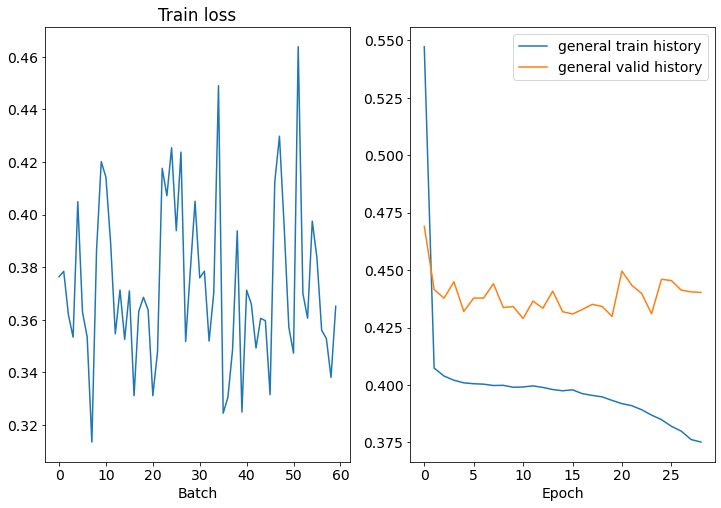

Epoch: 30 | Time: 0m 9s
	Train Loss: 0.371 | Train PPL:   1.449
	 Val. Loss: 0.485 |  Val. PPL:   1.624


In [28]:
enable_reproducibility()

USE_NOVELTY = False
model = SentenceTaggerRNN(vocab_size, use_novelty=USE_NOVELTY).to(DEVICE)

USE_CLASS_WEIGHTS = False
enable_reproducibility(raise_if_no_deterministic=False)
train(model, train_iterator, val_iterator, N_EPOCHS, CLIP, use_class_weights=USE_CLASS_WEIGHTS, lr=LEARNING_RATE)
enable_reproducibility()

 ### 1a. inference with top-k

In [29]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = True
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"1a: train w/o weights, inference w/ top-k (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Average length of summary (number of sentences): 3.0
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде . об этом сообщила официальный представитель мвд ирина волк . как уточнили в ведомстве , в полицию обратилась 40-летняя жительница москвы — она заявила , что к ее 11-летнего сыну жестоко относится учитель .
{'bleu': 0.4483358093852308,
 'rouge': {'rouge-1': {'f': 0.31733181247536896,
                       'p': 0.3031341514395032,
                       'r': 0.3531967563454

 ### 1b. inference with logit threshold

In [30]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = False
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"1b: train w/o weights, inference w/ logit threshold (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Warning! Some bad predictions gotten: 1/256 predictions are empty (fallback to lead-3)
Average length of summary (number of sentences): 1.0078125
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде .
{'bleu': 0.2076952462849269,
 'rouge': {'rouge-1': {'f': 0.28549881334798466,
                       'p': 0.45827007360175953,
                       'r': 0.21979142865843324},
           'rouge-2': {'f': 0.1394904263208491,
                       'p': 0.23684403559415051,
       

 ## 2. train with weights

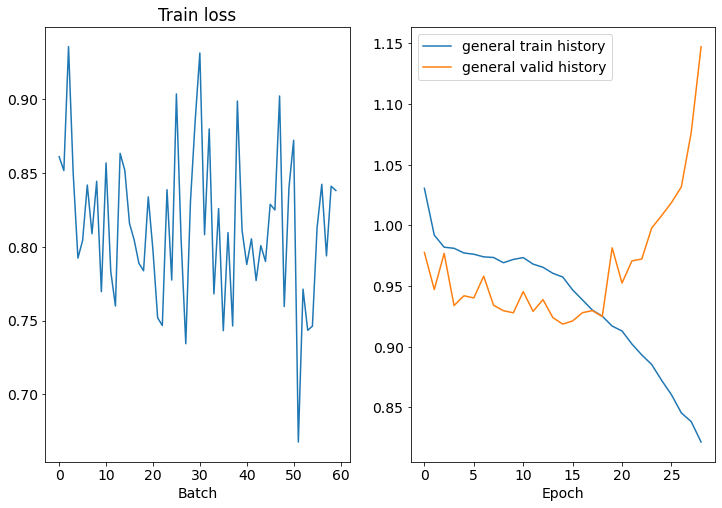

Epoch: 30 | Time: 0m 9s
	Train Loss: 0.814 | Train PPL:   2.257
	 Val. Loss: 1.125 |  Val. PPL:   3.079


In [31]:
enable_reproducibility()

USE_NOVELTY = False
model = SentenceTaggerRNN(vocab_size, use_novelty=USE_NOVELTY).to(DEVICE)

USE_CLASS_WEIGHTS = True
enable_reproducibility(raise_if_no_deterministic=False)
train(model, train_iterator, val_iterator, N_EPOCHS, CLIP, use_class_weights=USE_CLASS_WEIGHTS, lr=LEARNING_RATE)
enable_reproducibility()

 ### 2a. inference with top-k

In [32]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = True
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"2a: train w/ weights, inference w/ top-k (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Average length of summary (number of sentences): 3.0
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде . об этом сообщила официальный представитель мвд ирина волк . как уточнили в ведомстве , в полицию обратилась 40-летняя жительница москвы — она заявила , что к ее 11-летнего сыну жестоко относится учитель .
{'bleu': 0.4380764002159973,
 'rouge': {'rouge-1': {'f': 0.31557354398853676,
                       'p': 0.29564795301288954,
                       'r': 0.357454985588

 ### 2b. inference with logit threshold

In [33]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = False
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"2b: train w/ weights, inference w/ logit threshold (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Average length of summary (number of sentences): 9.65625
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде . об этом сообщила официальный представитель мвд ирина волк . как уточнили в ведомстве , в полицию обратилась 40-летняя жительница москвы — она заявила , что к ее 11-летнего сыну жестоко относится учитель . вскоре сотрудники правоохранительных органов задержали 41-летнюю екатерину тураносову . в отношении нее было возбуждено уголовное дело по статье 156 ук рф « неисполн

 ## Intermediate results

In [34]:
show_experiments_results_table()

,BLEU,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1
experiment,,,,
"1a: train w/o weights, inference w/ top-k (best-val, epochs 30, lr 1.0e-04)",0.448336,0.317332,0.142773,0.271546
"1b: train w/o weights, inference w/ logit threshold (best-val, epochs 30, lr 1.0e-04)",0.207695,0.285499,0.139490,0.210516
"2a: train w/ weights, inference w/ top-k (best-val, epochs 30, lr 1.0e-04)",0.438076,0.315574,0.142192,0.270138
"2b: train w/ weights, inference w/ logit threshold (best-val, epochs 30, lr 1.0e-04)",0.197090,0.247606,0.100074,0.162549


 ## 3. \[+novelty] train without weights

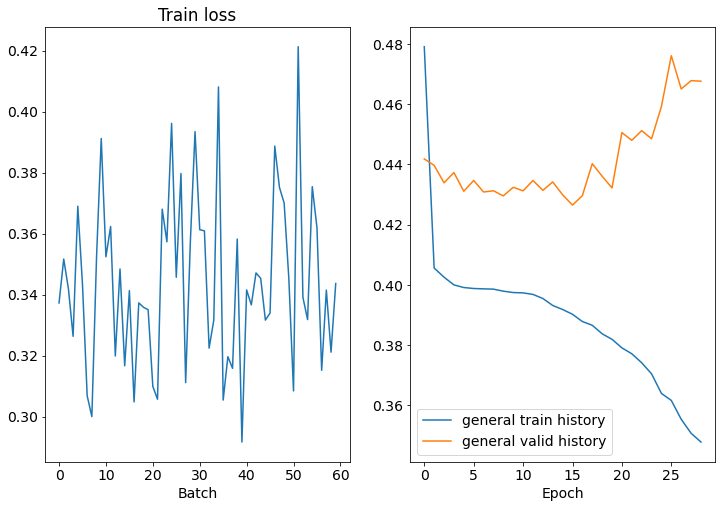

Epoch: 30 | Time: 0m 9s
	Train Loss: 0.343 | Train PPL:   1.408
	 Val. Loss: 0.511 |  Val. PPL:   1.668


In [35]:
enable_reproducibility()

USE_NOVELTY = True
model = SentenceTaggerRNN(vocab_size, use_novelty=USE_NOVELTY).to(DEVICE)

USE_CLASS_WEIGHTS = False
enable_reproducibility(raise_if_no_deterministic=False)
train(model, train_iterator, val_iterator, N_EPOCHS, CLIP, use_class_weights=USE_CLASS_WEIGHTS, lr=LEARNING_RATE)
enable_reproducibility()

 ### 3a. \[+novelty] inference with top-k

In [36]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = True
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"3a: [+novelty] train w/o weights, inference w/ top-k (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Average length of summary (number of sentences): 3.0
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде . об этом сообщила официальный представитель мвд ирина волк . как уточнили в ведомстве , в полицию обратилась 40-летняя жительница москвы — она заявила , что к ее 11-летнего сыну жестоко относится учитель .
{'bleu': 0.44020386946111023,
 'rouge': {'rouge-1': {'f': 0.3138125149106092,
                       'p': 0.2961898093375434,
                       'r': 0.3527794280310

 ### 3b. \[+novelty] inference with logit threshold

In [37]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = False
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"3b: [+novelty] train w/o weights, inference w/ logit threshold (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Warning! Some bad predictions gotten: 77/256 predictions are empty (fallback to lead-3)
Average length of summary (number of sentences): 1.6015625
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде .
{'bleu': 0.3467907522090057,
 'rouge': {'rouge-1': {'f': 0.29314580365442877,
                       'p': 0.41305277982417343,
                       'r': 0.26013314205763655},
           'rouge-2': {'f': 0.13872279376606111,
                       'p': 0.20793998684809314,
     

 ## 4. \[+novelty] train with weights

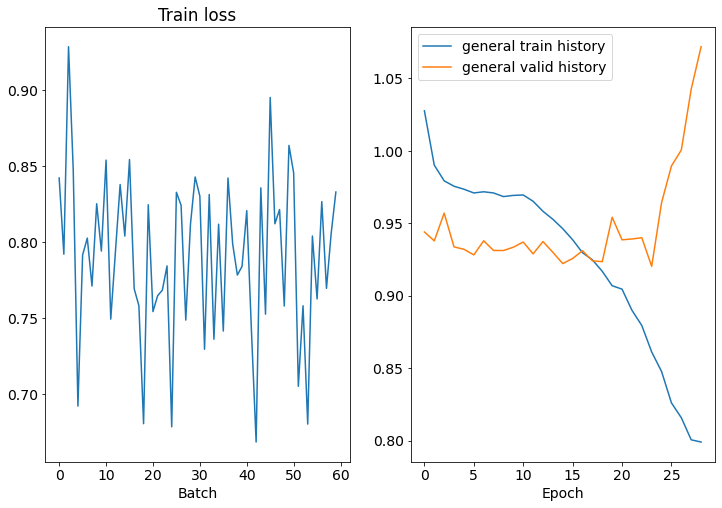

Epoch: 30 | Time: 0m 9s
	Train Loss: 0.789 | Train PPL:   2.202
	 Val. Loss: 1.056 |  Val. PPL:   2.876


In [38]:
enable_reproducibility()

USE_NOVELTY = True
model = SentenceTaggerRNN(vocab_size, use_novelty=USE_NOVELTY).to(DEVICE)

USE_CLASS_WEIGHTS = True
enable_reproducibility(raise_if_no_deterministic=False)
train(model, train_iterator, val_iterator, N_EPOCHS, CLIP, use_class_weights=USE_CLASS_WEIGHTS, lr=LEARNING_RATE)
enable_reproducibility()

 ### 4a. \[+novelty] inference with top-k

In [39]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = True
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"4a: [+novelty] train w/ weights, inference w/ top-k (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Average length of summary (number of sentences): 3.0
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде . об этом сообщила официальный представитель мвд ирина волк . в отношении нее было возбуждено уголовное дело по статье 156 ук рф « неисполнение обязанностей по воспитанию несовершеннолетнего » .
{'bleu': 0.4440430496336064,
 'rouge': {'rouge-1': {'f': 0.3133944037400121,
                       'p': 0.29750627178606065,
                       'r': 0.34892575756181243},
     

 ### 4b. \[+novelty] inference with logit threshold

In [40]:
model.load_state_dict(torch.load('best-val-model.pt'))
USE_LOGITS_RANKING = False
results = inference_summarunner(model, test_iterator, use_logits_ranking=USE_LOGITS_RANKING)
expr_name = f"4b: [+novelty] train w/ weights, inference w/ logit threshold (best-val, epochs {N_EPOCHS}, lr {LEARNING_RATE:.1e})"
add_experiment_results(expr_name, results)

Average length of summary (number of sentences): 9.88671875
Count: 256
Ref: после избиения учеников в одной из коррекционных школ москвы на преподавательницу завели уголовное дело . в полицию ранее обратилась мать одного из пострадавших школьников . тем временем после того , как педагога поместили под подписку о невыезде в рамках расследования , она подала встречный иск на родителей школьников . по ее мнению , они установили в кабинете скрытые камеры , хотя не имели на это права .
Hyp: на педагога одной из коррекционных школ москвы завели уголовное дело по факту избиения ребенка — женщина находится под подпиской о невыезде . об этом сообщила официальный представитель мвд ирина волк . как уточнили в ведомстве , в полицию обратилась 40-летняя жительница москвы — она заявила , что к ее 11-летнего сыну жестоко относится учитель . вскоре сотрудники правоохранительных органов задержали 41-летнюю екатерину тураносову . в отношении нее было возбуждено уголовное дело по статье 156 ук рф « неисп

 ## Вывод:

In [41]:
show_experiments_results_table()

,BLEU,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1
experiment,,,,
"1a: train w/o weights, inference w/ top-k (best-val, epochs 30, lr 1.0e-04)",0.448336,0.317332,0.142773,0.271546
"1b: train w/o weights, inference w/ logit threshold (best-val, epochs 30, lr 1.0e-04)",0.207695,0.285499,0.139490,0.210516
"2a: train w/ weights, inference w/ top-k (best-val, epochs 30, lr 1.0e-04)",0.438076,0.315574,0.142192,0.270138
"2b: train w/ weights, inference w/ logit threshold (best-val, epochs 30, lr 1.0e-04)",0.197090,0.247606,0.100074,0.162549
"3a: [+novelty] train w/o weights, inference w/ top-k (best-val, epochs 30, lr 1.0e-04)",0.440204,0.313813,0.141441,0.268615
"3b: [+novelty] train w/o weights, inference w/ logit threshold (best-val, epochs 30, lr 1.0e-04)",0.346791,0.293146,0.138723,0.223408
"4a: [+novelty] train w/ weights, inference w/ top-k (best-val, epochs 30, lr 1.0e-04)",0.444043,0.313394,0.141121,0.269548
"4b: [+novelty] train w/ weights, inference w/ logit threshold (best-val, epochs 30, lr 1.0e-04)",0.205127,0.249319,0.099492,0.164303


На модели обученной без весов при инференсе с выбором по порогу получаются пустые summary, поскольку модель меньше учится предсказывать положительный класс из несбалансированности классов. Я использовал в качества отката Lead-3. Качество, конечно, уступает инференсу с выбором самых вероятных предложений.

Инференсу с выбором по порогу не помогает даже обучение с весами: вместо пустых саммари модель предсказывает по ~10 предложений, что, видимо, уже слишком много, а потому по сравнению с обучением без весов и откату к Lead-3 на инференсе качество даже падает.

Обучение с novelty мешает или помогает в пределах погрешности всем вариантам кроме одного: обучение __без__ весов, инференс по порогу. Но это похоже на чистую случайность: модель вместо одного пустого саммари предсказала пустых ~30%, т.е. произошел массивный откат к Lead-3. По сути, novelty помешала.

Я пробовал изменять learning rate в широких и пределах и в ручную устанавливать фиксированные веса классов, и всегда модель выходит на плато, а потом идет резкое переобучение. Есть ощущение что какой-то жесткий фактор является потолком, который не позволяет доп. примочкам вроде novelty проявить себя.

Возможно, это размер датасета сам по себе или в сочетании с обучением эмбеддингов с нуля. В оригинальной работе авторы инициализируют их word2vec, претренированном на том же домене.